In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', index_col='id')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', index_col='id')
submission=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv', index_col='id')
print(train.shape, test.shape, submission.shape)

(188318, 131) (125546, 130) (125546, 1)


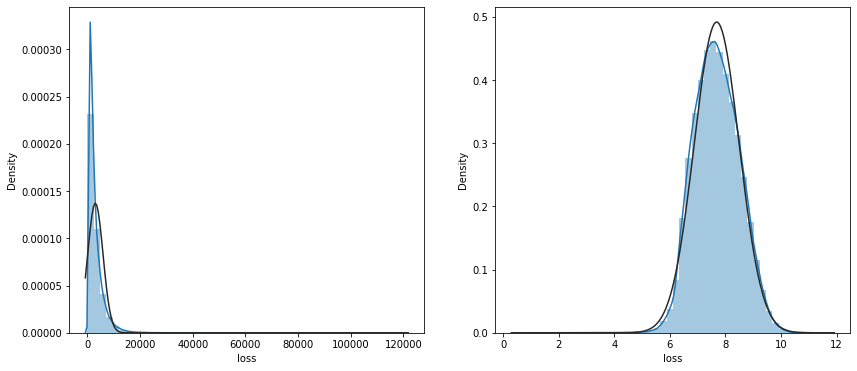

In [ ]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(train['loss'], fit=norm, ax=ax1)
sns.distplot(np.log(train['loss']+1), fit=norm, ax=ax2)

In [ ]:
train=train.drop(train.loc[train['loss']>40000].index)

In [ ]:
train['loss']=np.log(train['loss']+1)
Ytrain=train['loss']

In [ ]:
data=train
train=train[list(test)]
all_data=pd.concat((train, test))
all_data.shape

(313841, 130)

In [ ]:
cat_features=list(np.where(all_data.dtypes==np.object)[0])
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]


In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
non_numeric=list(all_data.select_dtypes(np.object))
for cols in non_numeric:
    le.fit(all_data[cols])
    all_data[cols]=le.transform(all_data[cols])

In [ ]:
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Ytrain.shape, Xtest.shape, submission.shape)

(188295, 130) (125546, 130)
(188295, 130) (188295,) (125546, 130) (125546, 1)


In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
model_xgb=XGBRegressor()
model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
model_LGB=LGBMRegressor()
model_LGB

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
model_LGB.fit(Xtrain, Ytrain)
model_xgb.fit(Xtrain, Ytrain)

lgb_predictions=model_LGB.predict(Xtest)
xgb_predictions=model_xgb.predict(Xtest)

[19:51:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
predictions=(lgb_predictions + xgb_predictions)/2

predictions=np.exp(predictions)-1
submission['loss']=predictions
submission.to_csv('Result.csv')
submission.head()

,loss
id,
4,1665.541080
6,2016.877888
9,8252.291342
12,5145.607526
15,903.870845
